# Colab specific

In [1]:
# from tqdm import tqdm

# nb_batches = 50

# # Install kaggle API - Upload your json token file by hand
# ! pip install -q kaggle

# # Upload kaggle.json by hand first !
# # Move the authentification file to the correct forlder
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

# # You are now good to use the Kaggle API to download files
# # ==============================================================================
# # Prepare folders
# ! mkdir -p ../kaggle/input/icecube-neutrinos-in-deep-ice/train/
# ! mkdir -p ../kaggle/input/icecube-neutrinos-in-deep-ice/test/

# # Get personal py files
# ! kaggle datasets download -d louisstefanuto/icecube-py
# ! unzip /content/icecube-py.zip
# ! rm /content/icecube-py.zip

# # Get sensor files
# ! kaggle competitions download icecube-neutrinos-in-deep-ice -f sensor_geometry.csv
# ! mv /content/sensor_geometry.csv ../kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv

# # Get preprocessed batches
# ! kaggle datasets download -d louisstefanuto/dataset-smallermeta
# ! unzip -nq /content/dataset-smallermeta.zip -d ../kaggle/input/smallermeta/
# ! rm /content/dataset-smallermeta.zip

# # Get test files
# ! kaggle competitions download icecube-neutrinos-in-deep-ice -f /test_meta.parquet
# ! mv /content/test_meta.parquet ../kaggle/input/icecube-neutrinos-in-deep-ice/test_meta.parquet
# ! kaggle competitions download icecube-neutrinos-in-deep-ice -f /test/batch_661.parquet
# ! mv /content/batch_661.parquet ../kaggle/input/icecube-neutrinos-in-deep-ice/test/batch_661.parquet
    
# # Get train batches
# for i in tqdm(range(nb_batches)):
#     PATH = f'/train/batch_{i+1}.parquet'
#     ! kaggle competitions download icecube-neutrinos-in-deep-ice -f $PATH

#     # Unzip files in their respective folder : -o to force overwrite / -n inverse
#     PATH = f'/content/batch_{i+1}.parquet.zip'
#     ! unzip -nq $PATH -d ../kaggle/input/icecube-neutrinos-in-deep-ice/train/
#     ! rm $PATH


# # Install PyTorch Geometric dependancies 
# import os
# import torch
# os.environ['TORCH'] = torch.__version__
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(torch.__version__)

# ! pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# ! pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# ! pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
# ! pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Kaggle specific

In [2]:
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
if device.type == 'cpu':
    # CPU version
    ! pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///kaggle/input/pytorch-geometric/PyTorch-Geometric
elif device.type == 'cuda':
    # GPU version
    ! pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///kaggle/input/pytorchgeometric
else:
    raise Exception('Bruh.')

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

from torch_geometric.loader import DataLoader

# Add python files
import sys
sys.path.append('/kaggle/input/icecube-py')

from dataset import MyOwnDataset
from metrics import angular_dist_score
import pred_to_angles

# Pytorch geometric data loading

In [5]:
%%time

dataset_args = {
    'idx_batch': 660, 
    'path_batch': '/kaggle/input/smallermeta/batch_660_small.parquet', 
    'path_meta': '/kaggle/input/smallermeta/val_meta_660_small.parquet', 
    'path_sensor': '/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv', 
    'target_mode': 'xyz', 
    'K': 8, 
    'features': ['x', 'y', 'z', 'time', 'charge'], 
    'threshold_events': 500
}

# Instantiate data set objects
val_dataset = MyOwnDataset(**dataset_args)

Preparing batch 660 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.

CPU times: user 620 ms, sys: 250 ms, total: 870 ms
Wall time: 943 ms


In [6]:
%%time
# Sanity check - Should return a graph = one event embedded.
# You should see that getting an event is much faster than building a data set.
# That is bc creating a data set requiers to create a DataFrame, while here we read only.
event, event_id = val_dataset.get(0) # id of the event within the batch selected to create the dataset object
event, event_id

CPU times: user 49.2 ms, sys: 2.82 ms, total: 52.1 ms
Wall time: 58.9 ms


(Data(x=[49, 5], y=[3], pos=[49, 3], n_pulses=49, edge_index=[2, 392]),
 2144984130)

In [7]:
def visualize_mesh(event):
    df_event = pd.DataFrame(event.pos.numpy(), columns = ['x', 'y', 'z'])
    edge_index = event.edge_index
    pos = event.pos
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    
    ax.scatter(df_event.x, df_event.y, df_event.z, s=100, c='r')
    
    for (src, dst) in edge_index.t().tolist():
        src = pos[src].tolist()
        dst = pos[dst].tolist()
        ax.plot([src[0], dst[0]], [src[1], dst[1]], [src[2], dst[2]], linewidth=1, color='black')
    
    plt.show()

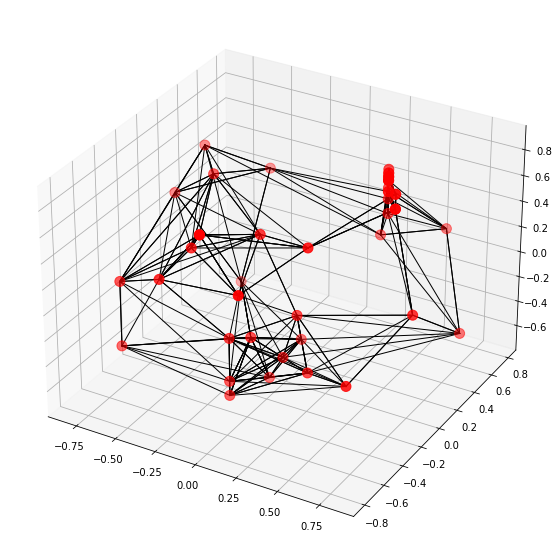

In [8]:
visualize_mesh(event)

In [9]:
BATCH_SIZE = 200 # In Graphnet baseline, = 200

# A DataLoader merges data objects from a torch_geometric.data.Dataset to a mini-batch.
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
# Let's ask the loader to return a batch!
for batch in val_loader:
    events, event_ids = batch
    print(events)
    break
    
print('Batchsize/num of graphs in batch:', events.num_graphs)
print('Num features per node:', events.num_features)
print('Event_ids:', event_ids)

DataBatch(x=[20476, 5], y=[600], pos=[20476, 3], n_pulses=[200], edge_index=[2, 165060], batch=[20476], ptr=[201])
Batchsize/num of graphs in batch: 200
Num features per node: 5
Event_ids: tensor([2144984130, 2144984139, 2144984142, 2144984185, 2144984191, 2144984218,
        2144984227, 2144984236, 2144984271, 2144984279, 2144984287, 2144984294,
        2144984324, 2144984338, 2144984349, 2144984391, 2144984403, 2144984437,
        2144984444, 2144984467, 2144984484, 2144984488, 2144984506, 2144984523,
        2144984565, 2144984566, 2144984568, 2144984578, 2144984586, 2144984596,
        2144984597, 2144984603, 2144984651, 2144984660, 2144984665, 2144984691,
        2144984720, 2144984747, 2144984751, 2144984761, 2144984762, 2144984765,
        2144984774, 2144984839, 2144984848, 2144984889, 2144984915, 2144984976,
        2144984999, 2144985029, 2144985037, 2144985044, 2144985055, 2144985068,
        2144985078, 2144985157, 2144985165, 2144985193, 2144985208, 2144985216,
        214

# Model

In [11]:
import torch
from torch.nn import Linear, LeakyReLU
from torch_geometric.nn import DynamicEdgeConv
from torch_geometric.nn import global_mean_pool
from torch import Tensor, LongTensor
from torch_scatter import scatter_mean
from torch_geometric.utils.homophily import homophily
from torch_geometric.nn.aggr import MultiAggregation, AttentionalAggregation


class EdgeConvMLP(torch.nn.Module):
    """Basic convolutional block."""
    def __init__(self, dim_in, dim_hidden, dim_out):
        super().__init__()

        self.sequential = torch.nn.Sequential(
            Linear(dim_in, dim_hidden),
            LeakyReLU(),
            Linear(dim_hidden, dim_out),
            LeakyReLU(),
        )

    def forward(self, x):
        return self.sequential(x)
    
class GateMLP(torch.nn.Module):
    """Basic convolutional block."""
    def __init__(self, dim_in, dim_hidden, dim_out):
        super().__init__()

        self.sequential = torch.nn.Sequential(
            Linear(dim_in, dim_hidden),
            LeakyReLU(),
            Linear(dim_hidden, dim_out),
            LeakyReLU(),
        )

    def forward(self, x):
        return self.sequential(x)


class DynEdgeAttention(torch.nn.Module):
    """Dynedge model from https://iopscience.iop.org/article/10.1088/1748-0221/17/11/P11003)"""
    def __init__(self, num_node_features, dim_output, dropout_rate=0.):
        super(DynEdgeAttention, self).__init__()
        
        torch.manual_seed(12345)
        self.num_node_features = num_node_features
        self.dim_output = dim_output
        self.dropout_rate = dropout_rate
        self.K = 8
#         self.aggrs_list = ['mean', 'min' , 'max', 'sum', AttentionalAggregation(gate_nn=GateMLP(256, 512, 256))]
        self.aggrs_list = [AttentionalAggregation(gate_nn=GateMLP(256, 64, 1))]

        self.conv1 = DynamicEdgeConv(nn=EdgeConvMLP(2 * self.num_node_features, 336, 256), k=self.K)
        self.conv2 = DynamicEdgeConv(nn=EdgeConvMLP(512, 336, 256), k=self.K)
        self.conv3 = DynamicEdgeConv(nn=EdgeConvMLP(512, 336, 256), k=self.K)
        self.conv4 = DynamicEdgeConv(nn=EdgeConvMLP(512, 336, 256), k=self.K)
        
        # final regressor
        self.mlp1 = torch.nn.Sequential(
            Linear(256 * 4 + self.num_node_features, 336),
            LeakyReLU(),
            Linear(336, 256),
            LeakyReLU(),
        )
        
        self.global_pool =  MultiAggregation(aggrs=self.aggrs_list)
        
#         mode_kwargs = {'in_channels': 256, 'out_channels': 256, 'num_heads': 16}
#         self.global_pool =  MultiAggregation(aggrs=self.aggrs_list, mode='attn', mode_kwargs=mode_kwargs)

#         AttentionalAggregation
#         self.attentional_aggr = AttentionalAggregation(gate_nn=GateMLP(256, 512, 256))

        self.mlp2 =  torch.nn.Sequential(
            Linear(len(self.aggrs_list) * 256 + (4 + self.num_node_features), 128), # input depends of number of aggregating fns + 4 homophily + mean_node
#             Linear(256 + (4 + self.num_node_features), 128),
            LeakyReLU(),
            Linear(128, self.dim_output)
        )


    def _calculate_global_variables(
        self,
        x: Tensor,
        edge_index: LongTensor,
        batch: LongTensor,
    ) -> Tensor:
        """Calculate global variables."""
        # Calculate homophily (scalar variables)
        h_x = homophily(edge_index, x[:, 0], batch).reshape(-1, 1)
        h_y = homophily(edge_index, x[:, 1], batch).reshape(-1, 1)
        h_z = homophily(edge_index, x[:, 2], batch).reshape(-1, 1)
        h_t = homophily(edge_index, x[:, 3], batch).reshape(-1, 1)
        
        # Calculate mean features
        global_means = scatter_mean(x, batch, dim=0)

        # Add global variables
        global_variables = torch.cat([global_means, h_x, h_y, h_z, h_t], dim=-1)

        return global_variables

    def forward(self, x, edge_index, batch):
        # 0. Obtain global variables
        global_x = self._calculate_global_variables(x, edge_index, batch)
        
        # 1. Obtain node embeddings at various embedding depths
        x1 = self.conv1(x, batch)
        x2 = self.conv2(x1, batch)
        x3 = self.conv3(x2, batch)
        x4 = self.conv4(x3, batch)

        x = torch.cat([x, x1, x2, x3, x4], dim=-1)
        
        x = self.mlp1(x)

        # 2. Pooling        
        x = self.global_pool(x, batch)
            
        x = torch.cat([global_x, x], dim=-1)

        # 3. Apply a final MLP regressor
        x = self.mlp2(x)
        
        return x

In [12]:
# Instantiate the model
model = DynEdgeAttention(
    num_node_features=event.x.shape[1], 
    dim_output=event.y.shape[0], 
    dropout_rate=0.
)

print(model)

DynEdgeAttention(
  (conv1): DynamicEdgeConv(nn=EdgeConvMLP(
    (sequential): Sequential(
      (0): Linear(in_features=10, out_features=336, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=336, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
  ), k=8)
  (conv2): DynamicEdgeConv(nn=EdgeConvMLP(
    (sequential): Sequential(
      (0): Linear(in_features=512, out_features=336, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=336, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
  ), k=8)
  (conv3): DynamicEdgeConv(nn=EdgeConvMLP(
    (sequential): Sequential(
      (0): Linear(in_features=512, out_features=336, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=336, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
  ), k=8)
  (conv4): DynamicEdgeConv(nn=EdgeConvMLP(
    (sequential): Sequential(
      (

In [13]:
# Sanity check - Forward pass with a batch
# You should get a prediction array of (BATCH_SIZE, dim_output) as output.
model(events.x, events.edge_index, events.batch).shape

torch.Size([200, 3])

In [14]:
# Try the metric on some data  
out = model(events.x, events.edge_index, events.batch)
# labels = events.y.reshape(len(events.n_pulses), -1)
labels = events.y.reshape(-1, model.dim_output)
   
target_mode = val_dataset.target_mode
if target_mode == 'angles':
    az_true, zen_true, az_pred, zen_pred = pred_to_angles.from_angles(out, labels)
if target_mode == 'cossin':        
    az_true, zen_true, az_pred, zen_pred = pred_to_angles.from_cossin(out, labels)
if target_mode == 'xyz':
    az_true, zen_true, az_pred, zen_pred = pred_to_angles.from_xyz(out, labels)

# Detach from GPU and send to CPU - convert to np to be accepted by host metric function
az_pred = az_pred.detach().cpu().numpy()
zen_pred = zen_pred.detach().cpu().numpy()
az_true = az_true.detach().cpu().numpy()
zen_true = zen_true.detach().cpu().numpy()
            
angular_dist_score(az_true, zen_true, az_pred, zen_pred)

1.4855133

# Von Mises loss

In [15]:
class VMFLoss(torch.nn.Module):
    def __init__(self):
        super(VMFLoss, self).__init__()

    def forward(self, output, target):
        return self._vMF_loss(output, target)

    def _vMF_loss(self, n_pred, n_true, eps = 1e-8):
        """  von Mises-Fisher Loss: n_true is unit vector ! """
        kappa = torch.norm(n_pred, dim=1)        
        logC = - kappa + torch.log((kappa + eps) / (1 - torch.exp(-2 * kappa) + 2 * eps))
        return - ((n_true * n_pred).sum(dim=1) + logC).mean() 

# Training

In [16]:
def run_one_epoch(model, loader, criterion, optimizer, device, epoch, train=True, verbose=0):
    """
    Training loop over one epoch.
    """
    if train:
        model.train()
    else:
        model.eval()
    
    total_loss = 0
    angle_error_sum = 0
    
    for id_batch, data in enumerate(tqdm(loader)): # Iterate over batches 
        
        # Load data and labels to device and predict
        events, event_ids = data
        x, edge_index, batch = events.x.to(device), events.edge_index.to(device), events.batch.to(device)
        labels = events.y.to(device).reshape(-1, model.dim_output) # reshape bc model returns (batchsize, dim_out), while loader (idiot!) returns (dim_out*batchsize)
        
        out = model(x, edge_index, batch) # Perform a single forward pass

        # Compute the loss - 
        loss = criterion(out, labels)  
        total_loss += loss.item() * events.num_graphs
        
        if train:
            # Back propagation
            loss.backward() # Derive gradients.
            optimizer.step() # Update parameters based on gradients.
            optimizer.zero_grad() # Clear gradients.
        
        # Metrics
        if target_mode == 'angles':
            az_true, zen_true, az_pred, zen_pred = pred_to_angles.from_angles(out, labels)
        if target_mode == 'cossin':        
            az_true, zen_true, az_pred, zen_pred = pred_to_angles.from_cossin(out, labels)
        if target_mode == 'xyz':
            az_true, zen_true, az_pred, zen_pred = pred_to_angles.from_xyz(out, labels)
        
        # Detach from GPU and send to CPU - convert to np to be accepted by host metric function
        az_pred = az_pred.detach().cpu().numpy()
        zen_pred = zen_pred.detach().cpu().numpy()
        az_true = az_true.detach().cpu().numpy()
        zen_true = zen_true.detach().cpu().numpy()
        
        angle_error = angular_dist_score(az_true, zen_true, az_pred, zen_pred)
        angle_error_sum += angle_error
        
        if verbose and id_batch % 100 == 0:
            if train:
                print(f'Epoch {epoch} - Batch {id_batch}/{len(loader)} - Loss {loss.item()} - Angle {angle_error}') 
            else:
                print(f'Epoch {epoch} - Batch {id_batch}/{len(loader)} - Val loss {loss.item()} - Val angle {angle_error}') 

    return total_loss / len(loader.dataset), angle_error_sum / len(loader)

In [17]:
NUM_EPOCHS = 20
offset = 70
LR0 = 1e-6

# regularization tools
WEIGHT_DECAY = 1e-3
DROPOUT_RATE = 0.

# callbacks
PATIENCE_LR_PLATEAU = 4
REDUCE_LR_FACTOR = 0.1
VERBOSE = 1

In [18]:
# Initalize your final model
model = DynEdgeAttention(
    num_node_features=event.x.shape[1], 
    dim_output=event.y.shape[0], 
    dropout_rate=DROPOUT_RATE
).to(device)

# Define save name - dirty
# TODO: hide training param into the dict when saving for reloading
SAVE_NAME = '03-06-dynedge+attention+xyz'
print(SAVE_NAME)

print(model)

03-06-dynedge+attention+xyz
DynEdgeAttention(
  (conv1): DynamicEdgeConv(nn=EdgeConvMLP(
    (sequential): Sequential(
      (0): Linear(in_features=10, out_features=336, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=336, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
  ), k=8)
  (conv2): DynamicEdgeConv(nn=EdgeConvMLP(
    (sequential): Sequential(
      (0): Linear(in_features=512, out_features=336, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=336, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
  ), k=8)
  (conv3): DynamicEdgeConv(nn=EdgeConvMLP(
    (sequential): Sequential(
      (0): Linear(in_features=512, out_features=336, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=336, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
  ), k=8)
  (conv4): DynamicEdgeConv(nn=EdgeConvMLP(
    (sequ

In [19]:
# criterion = torch.nn.MSELoss().to(device) # MSE
# criterion = torch.nn.L1Loss().to(device) # MAE
criterion = VMFLoss().to(device)

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=LR0, 
                             weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=REDUCE_LR_FACTOR, 
    patience=PATIENCE_LR_PLATEAU, 
    verbose=True)

In [20]:
# Learning from random initialization can be hard. 
# Transfer learning can help speeding up the learning process.
# If you have any pretrained model, load it here.

# PATH = '/content/24-02-dynedge+global+multi+xyz-0to45.pt' # None
PATH = '/kaggle/input/107-attention-vmf-0to70/03-05-dynedgeattentionxyz-0to70.pt'

if PATH is not None:
    model.load_state_dict(torch.load(PATH))
    print(model)

DynEdgeAttention(
  (conv1): DynamicEdgeConv(nn=EdgeConvMLP(
    (sequential): Sequential(
      (0): Linear(in_features=10, out_features=336, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=336, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
  ), k=8)
  (conv2): DynamicEdgeConv(nn=EdgeConvMLP(
    (sequential): Sequential(
      (0): Linear(in_features=512, out_features=336, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=336, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
  ), k=8)
  (conv3): DynamicEdgeConv(nn=EdgeConvMLP(
    (sequential): Sequential(
      (0): Linear(in_features=512, out_features=336, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=336, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
  ), k=8)
  (conv4): DynamicEdgeConv(nn=EdgeConvMLP(
    (sequential): Sequential(
      (

In [21]:
# Training cell
history = []

for epoch in range(1, NUM_EPOCHS+1):
    print(f'====== START EPOCH {epoch} ======')
    
    idx_batch = epoch + offset
    
    dataset_args = {
        'idx_batch': idx_batch,
        'path_batch': f'/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_{idx_batch}.parquet',
        'path_meta': f'/kaggle/input/smallermeta/train_meta_{idx_batch}.parquet', 
        'path_sensor': '/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv', 
        'target_mode': 'xyz', 
        'K': 8, 
        'features': ['x', 'y', 'z', 'time', 'charge'], 
        'threshold_events': 250
    }
    
    train_dataset = MyOwnDataset(**dataset_args)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    train_loss, angle_error = run_one_epoch(model, train_loader, criterion, optimizer, device, epoch, train=True, verbose=VERBOSE)
    val_loss, val_angle_error = run_one_epoch(model, val_loader, criterion, optimizer, device, epoch, train=False, verbose=VERBOSE)
    
    scheduler.step(val_loss)   
    
    # Save values for monitoring
    history.append((train_loss, angle_error, val_loss, val_angle_error))
    
    # Save model checkpoint
    torch.save(model.state_dict(), f'{SAVE_NAME}.pt')
    
    del train_dataset, train_loader
    gc.collect()
    
    print(f'Epoch {epoch:03d} - Loss {train_loss:.4f}, Angle {angle_error} - Val_loss {val_loss:.4f}, Val_angle {val_angle_error}')

====== START EPOCH 1 ======
Preparing batch 71 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:01<33:13,  2.00s/it]

Epoch 1 - Batch 0/1000 - Loss -0.2857603132724762 - Angle 1.0558247566223145


 10%|█         | 101/1000 [01:17<11:55,  1.26it/s]

Epoch 1 - Batch 100/1000 - Loss -0.06781700998544693 - Angle 1.116141676902771


 20%|██        | 201/1000 [02:33<10:16,  1.30it/s]

Epoch 1 - Batch 200/1000 - Loss -0.07130219042301178 - Angle 1.0627319812774658


 30%|███       | 301/1000 [03:48<08:36,  1.35it/s]

Epoch 1 - Batch 300/1000 - Loss -0.013831824995577335 - Angle 1.201012134552002


 40%|████      | 401/1000 [05:04<07:33,  1.32it/s]

Epoch 1 - Batch 400/1000 - Loss -0.23375335335731506 - Angle 1.067857027053833


 50%|█████     | 501/1000 [06:19<06:15,  1.33it/s]

Epoch 1 - Batch 500/1000 - Loss -0.18878521025180817 - Angle 1.0832055807113647


 60%|██████    | 601/1000 [07:34<05:16,  1.26it/s]

Epoch 1 - Batch 600/1000 - Loss -0.5774226188659668 - Angle 1.0161453485488892


 70%|███████   | 701/1000 [08:49<03:40,  1.36it/s]

Epoch 1 - Batch 700/1000 - Loss -0.017528094351291656 - Angle 1.1573970317840576


 80%|████████  | 801/1000 [10:04<02:29,  1.33it/s]

Epoch 1 - Batch 800/1000 - Loss -0.2459362894296646 - Angle 1.0156617164611816


 90%|█████████ | 901/1000 [11:19<01:17,  1.27it/s]

Epoch 1 - Batch 900/1000 - Loss -0.120754174888134 - Angle 1.1701699495315552


  1%|          | 1/100 [00:00<01:18,  1.25it/s]

Epoch 1 - Batch 0/100 - Val loss -0.30752119421958923 - Val angle 0.9737591743469238


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 001 - Loss -0.1524, Angle 1.0743765269517898 - Val_loss -0.1746, Val_angle 1.0744988805055617
====== START EPOCH 2 ======
Preparing batch 72 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<12:27,  1.34it/s]

Epoch 2 - Batch 0/1000 - Loss -0.23979972302913666 - Angle 1.0826046466827393


 10%|█         | 101/1000 [01:17<11:31,  1.30it/s]

Epoch 2 - Batch 100/1000 - Loss -0.027535580098628998 - Angle 0.9593618512153625


 20%|██        | 201/1000 [02:34<09:53,  1.35it/s]

Epoch 2 - Batch 200/1000 - Loss -0.3600176274776459 - Angle 1.0206973552703857


 30%|███       | 301/1000 [03:50<09:11,  1.27it/s]

Epoch 2 - Batch 300/1000 - Loss -0.08552508056163788 - Angle 1.067520022392273


 40%|████      | 401/1000 [05:06<07:35,  1.32it/s]

Epoch 2 - Batch 400/1000 - Loss -0.258853018283844 - Angle 1.0276168584823608


 50%|█████     | 501/1000 [06:20<06:33,  1.27it/s]

Epoch 2 - Batch 500/1000 - Loss -0.23888945579528809 - Angle 1.0418200492858887


 60%|██████    | 601/1000 [07:35<04:52,  1.36it/s]

Epoch 2 - Batch 600/1000 - Loss -0.06240696832537651 - Angle 1.1878410577774048


 70%|███████   | 701/1000 [08:49<03:39,  1.36it/s]

Epoch 2 - Batch 700/1000 - Loss -0.15328188240528107 - Angle 1.1758235692977905


 80%|████████  | 801/1000 [10:04<02:29,  1.33it/s]

Epoch 2 - Batch 800/1000 - Loss -0.13158394396305084 - Angle 1.086336612701416


 90%|█████████ | 901/1000 [11:18<01:13,  1.34it/s]

Epoch 2 - Batch 900/1000 - Loss -0.28516799211502075 - Angle 1.0614852905273438


  1%|          | 1/100 [00:00<01:16,  1.29it/s]

Epoch 2 - Batch 0/100 - Val loss -0.3194120228290558 - Val angle 0.9711961150169373


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 002 - Loss -0.1595, Angle 1.0736868356466294 - Val_loss -0.1727, Val_angle 1.0747650927305221
====== START EPOCH 3 ======
Preparing batch 73 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<15:26,  1.08it/s]

Epoch 3 - Batch 0/1000 - Loss -0.2802870571613312 - Angle 1.0851205587387085


 10%|█         | 101/1000 [01:15<10:37,  1.41it/s]

Epoch 3 - Batch 100/1000 - Loss -0.10720670223236084 - Angle 1.1087874174118042


 20%|██        | 201/1000 [02:31<09:51,  1.35it/s]

Epoch 3 - Batch 200/1000 - Loss -0.23848335444927216 - Angle 1.0404340028762817


 30%|███       | 301/1000 [03:46<08:24,  1.39it/s]

Epoch 3 - Batch 300/1000 - Loss 0.045170169323682785 - Angle 1.091923475265503


 40%|████      | 401/1000 [05:00<07:21,  1.36it/s]

Epoch 3 - Batch 400/1000 - Loss -0.18404866755008698 - Angle 1.1301683187484741


 50%|█████     | 501/1000 [06:17<06:42,  1.24it/s]

Epoch 3 - Batch 500/1000 - Loss 0.0438605472445488 - Angle 1.0365653038024902


 60%|██████    | 601/1000 [07:32<04:58,  1.34it/s]

Epoch 3 - Batch 600/1000 - Loss -0.3572006821632385 - Angle 1.0830929279327393


 70%|███████   | 701/1000 [08:47<04:00,  1.24it/s]

Epoch 3 - Batch 700/1000 - Loss -0.27918827533721924 - Angle 1.0523262023925781


 80%|████████  | 801/1000 [10:01<02:21,  1.41it/s]

Epoch 3 - Batch 800/1000 - Loss -0.06306277215480804 - Angle 1.0309078693389893


 90%|█████████ | 901/1000 [11:16<01:16,  1.29it/s]

Epoch 3 - Batch 900/1000 - Loss -0.22724631428718567 - Angle 0.9956398010253906


  1%|          | 1/100 [00:00<01:17,  1.28it/s]

Epoch 3 - Batch 0/100 - Val loss -0.31093719601631165 - Val angle 0.9714404344558716


100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 003 - Loss -0.1604, Angle 1.0726298059821129 - Val_loss -0.1708, Val_angle 1.0745183628797532
====== START EPOCH 4 ======
Preparing batch 74 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<13:42,  1.21it/s]

Epoch 4 - Batch 0/1000 - Loss -0.19499771296977997 - Angle 0.9565497040748596


 10%|█         | 101/1000 [01:16<11:27,  1.31it/s]

Epoch 4 - Batch 100/1000 - Loss -0.03399134427309036 - Angle 1.0781357288360596


 20%|██        | 201/1000 [02:31<09:45,  1.37it/s]

Epoch 4 - Batch 200/1000 - Loss 0.09432646632194519 - Angle 1.2379965782165527


 30%|███       | 301/1000 [03:46<08:36,  1.35it/s]

Epoch 4 - Batch 300/1000 - Loss -0.1818397045135498 - Angle 1.0949889421463013


 40%|████      | 401/1000 [05:01<07:30,  1.33it/s]

Epoch 4 - Batch 400/1000 - Loss -0.09715691953897476 - Angle 1.0876290798187256


 50%|█████     | 501/1000 [06:16<06:45,  1.23it/s]

Epoch 4 - Batch 500/1000 - Loss -0.3245306611061096 - Angle 0.9743390083312988


 60%|██████    | 601/1000 [07:31<04:55,  1.35it/s]

Epoch 4 - Batch 600/1000 - Loss -0.20846445858478546 - Angle 1.1423759460449219


 70%|███████   | 701/1000 [08:48<03:42,  1.34it/s]

Epoch 4 - Batch 700/1000 - Loss -0.21052704751491547 - Angle 1.063896656036377


 80%|████████  | 801/1000 [10:03<02:23,  1.39it/s]

Epoch 4 - Batch 800/1000 - Loss -0.6683148741722107 - Angle 0.8619316220283508


 90%|█████████ | 901/1000 [11:20<01:15,  1.30it/s]

Epoch 4 - Batch 900/1000 - Loss -0.16951410472393036 - Angle 1.0386289358139038


  1%|          | 1/100 [00:00<01:17,  1.28it/s]

Epoch 4 - Batch 0/100 - Val loss -0.32287609577178955 - Val angle 0.9716970920562744


100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Epoch 004 - Loss -0.1566, Angle 1.0752339725494384 - Val_loss -0.1723, Val_angle 1.0744280284643173
====== START EPOCH 5 ======
Preparing batch 75 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<14:20,  1.16it/s]

Epoch 5 - Batch 0/1000 - Loss -0.2158896028995514 - Angle 1.0083259344100952


 10%|█         | 101/1000 [01:16<11:56,  1.25it/s]

Epoch 5 - Batch 100/1000 - Loss -0.08247219026088715 - Angle 1.1229338645935059


 20%|██        | 201/1000 [02:32<11:14,  1.19it/s]

Epoch 5 - Batch 200/1000 - Loss -0.13578762114048004 - Angle 1.1277072429656982


 30%|███       | 301/1000 [03:48<08:36,  1.35it/s]

Epoch 5 - Batch 300/1000 - Loss -0.31611576676368713 - Angle 0.9734512567520142


 40%|████      | 401/1000 [05:03<07:16,  1.37it/s]

Epoch 5 - Batch 400/1000 - Loss -0.09965989738702774 - Angle 1.1274358034133911


 50%|█████     | 501/1000 [06:18<06:19,  1.32it/s]

Epoch 5 - Batch 500/1000 - Loss -0.29283925890922546 - Angle 1.0037307739257812


 60%|██████    | 601/1000 [07:32<04:46,  1.39it/s]

Epoch 5 - Batch 600/1000 - Loss -0.08350712805986404 - Angle 1.0468460321426392


 70%|███████   | 701/1000 [08:47<03:49,  1.30it/s]

Epoch 5 - Batch 700/1000 - Loss -0.2475215345621109 - Angle 1.022578239440918


 80%|████████  | 801/1000 [10:01<02:19,  1.43it/s]

Epoch 5 - Batch 800/1000 - Loss -0.13390417397022247 - Angle 1.1292500495910645


 90%|█████████ | 901/1000 [11:15<01:11,  1.39it/s]

Epoch 5 - Batch 900/1000 - Loss -0.12096124142408371 - Angle 1.0755325555801392


  1%|          | 1/100 [00:00<01:18,  1.26it/s]

Epoch 5 - Batch 0/100 - Val loss -0.3049702048301697 - Val angle 0.9741008877754211


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 005 - Loss -0.1642, Angle 1.0730407346487045 - Val_loss -0.1738, Val_angle 1.0738613200187683
====== START EPOCH 6 ======
Preparing batch 76 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<11:58,  1.39it/s]

Epoch 6 - Batch 0/1000 - Loss -0.16755107045173645 - Angle 1.0922755002975464


 10%|█         | 101/1000 [01:14<10:41,  1.40it/s]

Epoch 6 - Batch 100/1000 - Loss -0.05656227096915245 - Angle 1.1227788925170898


 20%|██        | 201/1000 [02:29<10:01,  1.33it/s]

Epoch 6 - Batch 200/1000 - Loss -0.14912590384483337 - Angle 1.0335168838500977


 30%|███       | 301/1000 [03:43<08:27,  1.38it/s]

Epoch 6 - Batch 300/1000 - Loss -0.2577838897705078 - Angle 1.0621638298034668


 40%|████      | 401/1000 [04:57<07:16,  1.37it/s]

Epoch 6 - Batch 400/1000 - Loss -0.041983891278505325 - Angle 0.9871720671653748


 50%|█████     | 501/1000 [06:12<06:13,  1.34it/s]

Epoch 6 - Batch 500/1000 - Loss -0.046897366642951965 - Angle 1.0534672737121582


 60%|██████    | 601/1000 [07:26<05:02,  1.32it/s]

Epoch 6 - Batch 600/1000 - Loss -0.3634558916091919 - Angle 1.0966204404830933


 70%|███████   | 701/1000 [08:40<03:39,  1.36it/s]

Epoch 6 - Batch 700/1000 - Loss -0.08830582350492477 - Angle 1.0870246887207031


 80%|████████  | 801/1000 [09:55<02:23,  1.39it/s]

Epoch 6 - Batch 800/1000 - Loss -0.235350102186203 - Angle 1.1255004405975342


 90%|█████████ | 901/1000 [11:09<01:12,  1.36it/s]

Epoch 6 - Batch 900/1000 - Loss -0.10771766304969788 - Angle 1.0982213020324707


  1%|          | 1/100 [00:00<01:15,  1.32it/s]

Epoch 6 - Batch 0/100 - Val loss -0.2933681607246399 - Val angle 0.975554347038269


100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 00006: reducing learning rate of group 0 to 1.0000e-07.
Epoch 006 - Loss -0.1553, Angle 1.0717059507369995 - Val_loss -0.1739, Val_angle 1.0738251221179962
====== START EPOCH 7 ======
Preparing batch 77 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<12:23,  1.34it/s]

Epoch 7 - Batch 0/1000 - Loss -0.46319320797920227 - Angle 1.005223274230957


 10%|█         | 101/1000 [01:15<11:28,  1.31it/s]

Epoch 7 - Batch 100/1000 - Loss -0.27951857447624207 - Angle 1.0442527532577515


 20%|██        | 201/1000 [02:29<09:50,  1.35it/s]

Epoch 7 - Batch 200/1000 - Loss -0.04666605964303017 - Angle 1.1132967472076416


 30%|███       | 301/1000 [03:43<08:39,  1.34it/s]

Epoch 7 - Batch 300/1000 - Loss -0.3053283095359802 - Angle 1.0496219396591187


 40%|████      | 401/1000 [04:58<07:15,  1.38it/s]

Epoch 7 - Batch 400/1000 - Loss -0.1348353922367096 - Angle 1.115407109260559


 50%|█████     | 501/1000 [06:13<06:15,  1.33it/s]

Epoch 7 - Batch 500/1000 - Loss 0.028310338035225868 - Angle 1.0697346925735474


 60%|██████    | 601/1000 [07:27<04:57,  1.34it/s]

Epoch 7 - Batch 600/1000 - Loss -0.15989597141742706 - Angle 1.084427833557129


 70%|███████   | 701/1000 [08:42<03:48,  1.31it/s]

Epoch 7 - Batch 700/1000 - Loss -0.3721961975097656 - Angle 1.065406084060669


 80%|████████  | 801/1000 [09:55<02:21,  1.41it/s]

Epoch 7 - Batch 800/1000 - Loss -0.09584879875183105 - Angle 1.130077838897705


 90%|█████████ | 901/1000 [11:09<01:13,  1.34it/s]

Epoch 7 - Batch 900/1000 - Loss -0.15752936899662018 - Angle 1.0662600994110107


  1%|          | 1/100 [00:00<01:15,  1.30it/s]

Epoch 7 - Batch 0/100 - Val loss -0.30962276458740234 - Val angle 0.9737507700920105


100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


Epoch 007 - Loss -0.1550, Angle 1.0765408371686935 - Val_loss -0.1744, Val_angle 1.0737359315156936
====== START EPOCH 8 ======
Preparing batch 78 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<15:09,  1.10it/s]

Epoch 8 - Batch 0/1000 - Loss -0.041313476860523224 - Angle 1.067537546157837


 10%|█         | 101/1000 [01:14<11:15,  1.33it/s]

Epoch 8 - Batch 100/1000 - Loss -0.15540845692157745 - Angle 0.9866651892662048


 20%|██        | 201/1000 [02:28<10:02,  1.33it/s]

Epoch 8 - Batch 200/1000 - Loss -0.40309011936187744 - Angle 1.0282729864120483


 30%|███       | 301/1000 [03:42<08:35,  1.36it/s]

Epoch 8 - Batch 300/1000 - Loss -0.046397916972637177 - Angle 1.1345325708389282


 40%|████      | 401/1000 [04:59<07:44,  1.29it/s]

Epoch 8 - Batch 400/1000 - Loss -0.2512945830821991 - Angle 1.0620273351669312


 50%|█████     | 501/1000 [06:15<06:23,  1.30it/s]

Epoch 8 - Batch 500/1000 - Loss -0.16393828392028809 - Angle 1.0801610946655273


 60%|██████    | 601/1000 [07:30<04:40,  1.42it/s]

Epoch 8 - Batch 600/1000 - Loss 0.3024257719516754 - Angle 1.0442872047424316


 70%|███████   | 701/1000 [08:44<03:34,  1.40it/s]

Epoch 8 - Batch 700/1000 - Loss -0.028881588950753212 - Angle 1.0648086071014404


 80%|████████  | 801/1000 [09:59<02:29,  1.33it/s]

Epoch 8 - Batch 800/1000 - Loss -0.190510556101799 - Angle 1.0295008420944214


 90%|█████████ | 901/1000 [11:14<01:12,  1.37it/s]

Epoch 8 - Batch 900/1000 - Loss -0.25738877058029175 - Angle 1.1098119020462036


  1%|          | 1/100 [00:00<01:16,  1.30it/s]

Epoch 8 - Batch 0/100 - Val loss -0.30165693163871765 - Val angle 0.9759124517440796


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 008 - Loss -0.1594, Angle 1.0733144830465318 - Val_loss -0.1733, Val_angle 1.07419289290905
====== START EPOCH 9 ======
Preparing batch 79 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<12:39,  1.31it/s]

Epoch 9 - Batch 0/1000 - Loss 0.015179209411144257 - Angle 1.0450067520141602


 10%|█         | 101/1000 [01:15<10:55,  1.37it/s]

Epoch 9 - Batch 100/1000 - Loss -0.20327195525169373 - Angle 1.0865051746368408


 20%|██        | 201/1000 [02:29<09:48,  1.36it/s]

Epoch 9 - Batch 200/1000 - Loss -0.3377329111099243 - Angle 0.9865910410881042


 30%|███       | 301/1000 [03:43<08:29,  1.37it/s]

Epoch 9 - Batch 300/1000 - Loss 0.12117860466241837 - Angle 1.1252909898757935


 40%|████      | 401/1000 [04:59<07:28,  1.33it/s]

Epoch 9 - Batch 400/1000 - Loss -0.26002582907676697 - Angle 0.9809826612472534


 50%|█████     | 501/1000 [06:13<06:17,  1.32it/s]

Epoch 9 - Batch 500/1000 - Loss -0.09660350531339645 - Angle 1.0600684881210327


 60%|██████    | 601/1000 [07:28<05:39,  1.18it/s]

Epoch 9 - Batch 600/1000 - Loss 0.06638943403959274 - Angle 1.1503678560256958


 70%|███████   | 701/1000 [08:43<03:42,  1.34it/s]

Epoch 9 - Batch 700/1000 - Loss -0.3322717845439911 - Angle 1.0282269716262817


 80%|████████  | 801/1000 [09:57<02:27,  1.35it/s]

Epoch 9 - Batch 800/1000 - Loss -0.21992526948451996 - Angle 1.0653996467590332


 90%|█████████ | 901/1000 [11:13<01:21,  1.22it/s]

Epoch 9 - Batch 900/1000 - Loss -0.12172065675258636 - Angle 1.1442543268203735


  1%|          | 1/100 [00:00<01:23,  1.18it/s]

Epoch 9 - Batch 0/100 - Val loss -0.28019893169403076 - Val angle 0.9762254357337952


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 009 - Loss -0.1606, Angle 1.0744521536231042 - Val_loss -0.1721, Val_angle 1.0742783546447754
====== START EPOCH 10 ======
Preparing batch 80 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<15:16,  1.09it/s]

Epoch 10 - Batch 0/1000 - Loss -0.1545419991016388 - Angle 1.0432490110397339


 10%|█         | 101/1000 [01:15<10:52,  1.38it/s]

Epoch 10 - Batch 100/1000 - Loss -0.11816384643316269 - Angle 1.1424633264541626


 20%|██        | 201/1000 [02:28<09:41,  1.37it/s]

Epoch 10 - Batch 200/1000 - Loss -0.29058292508125305 - Angle 1.012381911277771


 30%|███       | 301/1000 [03:43<08:42,  1.34it/s]

Epoch 10 - Batch 300/1000 - Loss -0.331764280796051 - Angle 1.075770378112793


 40%|████      | 401/1000 [04:57<07:10,  1.39it/s]

Epoch 10 - Batch 400/1000 - Loss -0.33872076869010925 - Angle 0.9814982414245605


 50%|█████     | 501/1000 [06:12<06:18,  1.32it/s]

Epoch 10 - Batch 500/1000 - Loss -0.17052166163921356 - Angle 1.1138828992843628


 60%|██████    | 601/1000 [07:28<04:55,  1.35it/s]

Epoch 10 - Batch 600/1000 - Loss -0.18002963066101074 - Angle 1.0376741886138916


 70%|███████   | 701/1000 [08:42<03:39,  1.36it/s]

Epoch 10 - Batch 700/1000 - Loss 0.14121344685554504 - Angle 1.1341156959533691


 80%|████████  | 801/1000 [09:57<02:51,  1.16it/s]

Epoch 10 - Batch 800/1000 - Loss 0.0503668338060379 - Angle 1.1934694051742554


 90%|█████████ | 901/1000 [11:11<01:10,  1.40it/s]

Epoch 10 - Batch 900/1000 - Loss -0.18041402101516724 - Angle 1.0937983989715576


  1%|          | 1/100 [00:00<01:17,  1.28it/s]

Epoch 10 - Batch 0/100 - Val loss -0.3137318789958954 - Val angle 0.9710952639579773


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 010 - Loss -0.1577, Angle 1.0727965012192726 - Val_loss -0.1740, Val_angle 1.073908467888832
====== START EPOCH 11 ======
Preparing batch 81 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<15:45,  1.06it/s]

Epoch 11 - Batch 0/1000 - Loss -0.15329734981060028 - Angle 0.999701738357544


 10%|█         | 101/1000 [01:15<10:46,  1.39it/s]

Epoch 11 - Batch 100/1000 - Loss -0.03502104803919792 - Angle 1.139415979385376


 20%|██        | 201/1000 [02:32<10:38,  1.25it/s]

Epoch 11 - Batch 200/1000 - Loss -0.06923680007457733 - Angle 1.15571928024292


 30%|███       | 301/1000 [03:46<08:32,  1.36it/s]

Epoch 11 - Batch 300/1000 - Loss -0.018726658076047897 - Angle 1.1078165769577026


 40%|████      | 401/1000 [05:01<07:26,  1.34it/s]

Epoch 11 - Batch 400/1000 - Loss -0.08010946214199066 - Angle 1.1710636615753174


 50%|█████     | 501/1000 [06:17<06:56,  1.20it/s]

Epoch 11 - Batch 500/1000 - Loss -0.232754185795784 - Angle 1.0368026494979858


 60%|██████    | 601/1000 [07:32<04:50,  1.38it/s]

Epoch 11 - Batch 600/1000 - Loss -0.23132246732711792 - Angle 1.029094934463501


 70%|███████   | 701/1000 [08:46<03:34,  1.39it/s]

Epoch 11 - Batch 700/1000 - Loss 0.07527078688144684 - Angle 1.1321232318878174


 80%|████████  | 801/1000 [10:02<02:34,  1.29it/s]

Epoch 11 - Batch 800/1000 - Loss -0.0705125629901886 - Angle 1.1209293603897095


 90%|█████████ | 901/1000 [11:17<01:14,  1.34it/s]

Epoch 11 - Batch 900/1000 - Loss -0.2176467478275299 - Angle 1.1015267372131348


  1%|          | 1/100 [00:00<01:21,  1.22it/s]

Epoch 11 - Batch 0/100 - Val loss -0.2999294400215149 - Val angle 0.9751663208007812


100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 00011: reducing learning rate of group 0 to 1.0000e-08.
Epoch 011 - Loss -0.1563, Angle 1.0727381873726844 - Val_loss -0.1735, Val_angle 1.074284810423851
====== START EPOCH 12 ======
Preparing batch 82 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<12:35,  1.32it/s]

Epoch 12 - Batch 0/1000 - Loss 0.14325641095638275 - Angle 1.1378682851791382


 10%|█         | 101/1000 [01:15<11:41,  1.28it/s]

Epoch 12 - Batch 100/1000 - Loss -0.31478002667427063 - Angle 1.0625282526016235


 20%|██        | 201/1000 [02:28<09:31,  1.40it/s]

Epoch 12 - Batch 200/1000 - Loss -0.35345855355262756 - Angle 0.9804968237876892


 30%|███       | 301/1000 [03:42<08:31,  1.37it/s]

Epoch 12 - Batch 300/1000 - Loss -0.20651310682296753 - Angle 1.1018834114074707


 40%|████      | 401/1000 [04:56<07:16,  1.37it/s]

Epoch 12 - Batch 400/1000 - Loss 0.377871572971344 - Angle 1.1346418857574463


 50%|█████     | 501/1000 [06:10<06:19,  1.32it/s]

Epoch 12 - Batch 500/1000 - Loss -0.28187334537506104 - Angle 0.9201667904853821


 60%|██████    | 601/1000 [07:23<04:59,  1.33it/s]

Epoch 12 - Batch 600/1000 - Loss -0.18845653533935547 - Angle 1.1115922927856445


 70%|███████   | 701/1000 [08:37<03:34,  1.39it/s]

Epoch 12 - Batch 700/1000 - Loss -0.2297934740781784 - Angle 1.0831503868103027


 80%|████████  | 801/1000 [09:52<02:28,  1.34it/s]

Epoch 12 - Batch 800/1000 - Loss 0.04162260890007019 - Angle 1.1347498893737793


 90%|█████████ | 901/1000 [11:06<01:14,  1.33it/s]

Epoch 12 - Batch 900/1000 - Loss -0.2793440520763397 - Angle 1.0447564125061035


  1%|          | 1/100 [00:00<01:15,  1.32it/s]

Epoch 12 - Batch 0/100 - Val loss -0.31396475434303284 - Val angle 0.9692752361297607


100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


Epoch 012 - Loss -0.1608, Angle 1.071110277235508 - Val_loss -0.1738, Val_angle 1.073753924369812
====== START EPOCH 13 ======
Preparing batch 83 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<12:00,  1.39it/s]

Epoch 13 - Batch 0/1000 - Loss -0.25928831100463867 - Angle 1.1300426721572876


 10%|█         | 101/1000 [01:15<11:53,  1.26it/s]

Epoch 13 - Batch 100/1000 - Loss -0.3147732615470886 - Angle 1.036515235900879


 20%|██        | 201/1000 [02:28<09:24,  1.42it/s]

Epoch 13 - Batch 200/1000 - Loss -0.2718695104122162 - Angle 0.9792180061340332


 30%|███       | 301/1000 [03:42<08:32,  1.37it/s]

Epoch 13 - Batch 300/1000 - Loss -0.15439437329769135 - Angle 1.0641660690307617


 40%|████      | 401/1000 [04:57<07:42,  1.29it/s]

Epoch 13 - Batch 400/1000 - Loss -0.06176554039120674 - Angle 1.1126513481140137


 50%|█████     | 501/1000 [06:11<06:21,  1.31it/s]

Epoch 13 - Batch 500/1000 - Loss -0.044255580753088 - Angle 1.1282333135604858


 60%|██████    | 601/1000 [07:25<04:52,  1.36it/s]

Epoch 13 - Batch 600/1000 - Loss -0.11708199977874756 - Angle 1.0867666006088257


 70%|███████   | 701/1000 [08:39<03:41,  1.35it/s]

Epoch 13 - Batch 700/1000 - Loss 0.046853579580783844 - Angle 1.144946575164795


 80%|████████  | 801/1000 [09:53<02:23,  1.39it/s]

Epoch 13 - Batch 800/1000 - Loss -0.09563391655683517 - Angle 1.085269570350647


 90%|█████████ | 901/1000 [11:07<01:12,  1.37it/s]

Epoch 13 - Batch 900/1000 - Loss -0.2506149113178253 - Angle 1.0024645328521729


  1%|          | 1/100 [00:00<01:14,  1.32it/s]

Epoch 13 - Batch 0/100 - Val loss -0.2978515326976776 - Val angle 0.9772871136665344


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 013 - Loss -0.1600, Angle 1.072702508866787 - Val_loss -0.1750, Val_angle 1.0736791735887528
====== START EPOCH 14 ======
Preparing batch 84 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<12:14,  1.36it/s]

Epoch 14 - Batch 0/1000 - Loss -0.0765862986445427 - Angle 1.1422398090362549


 10%|█         | 101/1000 [01:15<11:46,  1.27it/s]

Epoch 14 - Batch 100/1000 - Loss -0.16598765552043915 - Angle 1.0836137533187866


 20%|██        | 201/1000 [02:28<09:41,  1.38it/s]

Epoch 14 - Batch 200/1000 - Loss 0.1467447280883789 - Angle 1.2601513862609863


 30%|███       | 301/1000 [03:42<08:03,  1.45it/s]

Epoch 14 - Batch 300/1000 - Loss -0.3662135601043701 - Angle 1.0437012910842896


 40%|████      | 401/1000 [04:56<07:37,  1.31it/s]

Epoch 14 - Batch 400/1000 - Loss -0.5556185841560364 - Angle 0.9449501633644104


 50%|█████     | 501/1000 [06:10<06:26,  1.29it/s]

Epoch 14 - Batch 500/1000 - Loss -0.30385586619377136 - Angle 1.0120660066604614


 60%|██████    | 601/1000 [07:25<05:08,  1.29it/s]

Epoch 14 - Batch 600/1000 - Loss -0.3952518105506897 - Angle 0.9685783386230469


 70%|███████   | 701/1000 [08:39<03:48,  1.31it/s]

Epoch 14 - Batch 700/1000 - Loss -0.1208590492606163 - Angle 1.0962470769882202


 80%|████████  | 801/1000 [09:53<02:18,  1.44it/s]

Epoch 14 - Batch 800/1000 - Loss -0.10077998042106628 - Angle 1.0393617153167725


 90%|█████████ | 901/1000 [11:06<01:12,  1.36it/s]

Epoch 14 - Batch 900/1000 - Loss -0.11095650494098663 - Angle 1.0577257871627808


  1%|          | 1/100 [00:00<01:17,  1.28it/s]

Epoch 14 - Batch 0/100 - Val loss -0.30324164032936096 - Val angle 0.9739863872528076


100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


Epoch 014 - Loss -0.1595, Angle 1.0703322615027429 - Val_loss -0.1746, Val_angle 1.0736190658807754
====== START EPOCH 15 ======
Preparing batch 85 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<13:34,  1.23it/s]

Epoch 15 - Batch 0/1000 - Loss -0.17667677998542786 - Angle 1.044213056564331


 10%|█         | 101/1000 [01:15<13:10,  1.14it/s]

Epoch 15 - Batch 100/1000 - Loss -0.09082383662462234 - Angle 1.1744424104690552


 20%|██        | 201/1000 [02:28<09:21,  1.42it/s]

Epoch 15 - Batch 200/1000 - Loss -0.1944637894630432 - Angle 1.0213207006454468


 30%|███       | 301/1000 [03:43<08:33,  1.36it/s]

Epoch 15 - Batch 300/1000 - Loss -0.20419539511203766 - Angle 1.0352952480316162


 40%|████      | 401/1000 [04:58<07:57,  1.25it/s]

Epoch 15 - Batch 400/1000 - Loss -0.16743111610412598 - Angle 1.0621861219406128


 50%|█████     | 501/1000 [06:12<06:26,  1.29it/s]

Epoch 15 - Batch 500/1000 - Loss -0.21820349991321564 - Angle 1.1001304388046265


 60%|██████    | 601/1000 [07:26<04:51,  1.37it/s]

Epoch 15 - Batch 600/1000 - Loss -0.15798431634902954 - Angle 1.0977487564086914


 70%|███████   | 701/1000 [08:40<04:01,  1.24it/s]

Epoch 15 - Batch 700/1000 - Loss -0.13936077058315277 - Angle 1.068066120147705


 80%|████████  | 801/1000 [09:54<02:24,  1.37it/s]

Epoch 15 - Batch 800/1000 - Loss -0.23913417756557465 - Angle 0.9543583393096924


 90%|█████████ | 901/1000 [11:08<01:13,  1.34it/s]

Epoch 15 - Batch 900/1000 - Loss 0.12056251615285873 - Angle 1.1024682521820068


  1%|          | 1/100 [00:00<01:36,  1.03it/s]

Epoch 15 - Batch 0/100 - Val loss -0.299155056476593 - Val angle 0.9771371483802795


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 015 - Loss -0.1586, Angle 1.0737765522003173 - Val_loss -0.1735, Val_angle 1.074096127152443
====== START EPOCH 16 ======
Preparing batch 86 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<12:01,  1.38it/s]

Epoch 16 - Batch 0/1000 - Loss -0.18859192728996277 - Angle 1.105505347251892


 10%|█         | 101/1000 [01:14<10:54,  1.37it/s]

Epoch 16 - Batch 100/1000 - Loss -0.1821298599243164 - Angle 1.0142902135849


 20%|██        | 201/1000 [02:28<09:44,  1.37it/s]

Epoch 16 - Batch 200/1000 - Loss -0.1417233794927597 - Angle 1.0475821495056152


 30%|███       | 301/1000 [03:42<08:31,  1.37it/s]

Epoch 16 - Batch 300/1000 - Loss -0.005423123482614756 - Angle 1.1239182949066162


 40%|████      | 401/1000 [04:56<07:34,  1.32it/s]

Epoch 16 - Batch 400/1000 - Loss -0.012243195436894894 - Angle 1.1984363794326782


 50%|█████     | 501/1000 [06:10<06:15,  1.33it/s]

Epoch 16 - Batch 500/1000 - Loss -0.45141422748565674 - Angle 0.9793485999107361


 60%|██████    | 601/1000 [07:24<04:42,  1.41it/s]

Epoch 16 - Batch 600/1000 - Loss -0.26694729924201965 - Angle 1.0733518600463867


 70%|███████   | 701/1000 [08:38<03:36,  1.38it/s]

Epoch 16 - Batch 700/1000 - Loss -0.14304304122924805 - Angle 1.1430072784423828


 80%|████████  | 801/1000 [09:53<02:27,  1.35it/s]

Epoch 16 - Batch 800/1000 - Loss -0.23404298722743988 - Angle 1.1183044910430908


 90%|█████████ | 901/1000 [11:06<01:11,  1.39it/s]

Epoch 16 - Batch 900/1000 - Loss -0.20207612216472626 - Angle 1.1128134727478027


  1%|          | 1/100 [00:00<01:15,  1.32it/s]

Epoch 16 - Batch 0/100 - Val loss -0.3233821392059326 - Val angle 0.9688524603843689


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 016 - Loss -0.1628, Angle 1.074284320473671 - Val_loss -0.1747, Val_angle 1.0733536887168884
====== START EPOCH 17 ======
Preparing batch 87 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<12:42,  1.31it/s]

Epoch 17 - Batch 0/1000 - Loss -0.04414904862642288 - Angle 1.0834776163101196


 10%|█         | 101/1000 [01:14<10:53,  1.38it/s]

Epoch 17 - Batch 100/1000 - Loss -0.16445991396903992 - Angle 1.1613696813583374


 20%|██        | 201/1000 [02:29<10:29,  1.27it/s]

Epoch 17 - Batch 200/1000 - Loss 0.027813663706183434 - Angle 1.1655114889144897


 30%|███       | 301/1000 [03:43<08:41,  1.34it/s]

Epoch 17 - Batch 300/1000 - Loss -0.062060993164777756 - Angle 1.1393022537231445


 40%|████      | 401/1000 [04:57<07:14,  1.38it/s]

Epoch 17 - Batch 400/1000 - Loss -0.5356799960136414 - Angle 0.9956068396568298


 50%|█████     | 501/1000 [06:11<06:42,  1.24it/s]

Epoch 17 - Batch 500/1000 - Loss -0.32416319847106934 - Angle 0.9982133507728577


 60%|██████    | 601/1000 [07:24<04:51,  1.37it/s]

Epoch 17 - Batch 600/1000 - Loss -0.26371049880981445 - Angle 1.0123296976089478


 70%|███████   | 701/1000 [08:37<03:33,  1.40it/s]

Epoch 17 - Batch 700/1000 - Loss -0.10664365440607071 - Angle 1.0995055437088013


 80%|████████  | 801/1000 [09:51<02:21,  1.40it/s]

Epoch 17 - Batch 800/1000 - Loss -0.3383129835128784 - Angle 1.001935601234436


 90%|█████████ | 901/1000 [11:06<01:17,  1.28it/s]

Epoch 17 - Batch 900/1000 - Loss -0.35431936383247375 - Angle 0.9551958441734314


  1%|          | 1/100 [00:00<01:18,  1.25it/s]

Epoch 17 - Batch 0/100 - Val loss -0.31313133239746094 - Val angle 0.9693896770477295


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 017 - Loss -0.1612, Angle 1.0706382813453674 - Val_loss -0.1740, Val_angle 1.074090563058853
====== START EPOCH 18 ======
Preparing batch 88 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:01<22:20,  1.34s/it]

Epoch 18 - Batch 0/1000 - Loss -0.4611559808254242 - Angle 1.0346060991287231


 10%|█         | 101/1000 [01:15<10:49,  1.38it/s]

Epoch 18 - Batch 100/1000 - Loss -0.08572500199079514 - Angle 1.1401187181472778


 20%|██        | 201/1000 [02:29<09:52,  1.35it/s]

Epoch 18 - Batch 200/1000 - Loss 0.053380753844976425 - Angle 1.1141072511672974


 30%|███       | 301/1000 [03:44<08:18,  1.40it/s]

Epoch 18 - Batch 300/1000 - Loss -0.1733645349740982 - Angle 1.0397343635559082


 40%|████      | 401/1000 [04:58<07:25,  1.35it/s]

Epoch 18 - Batch 400/1000 - Loss -0.626977801322937 - Angle 0.9108036756515503


 50%|█████     | 501/1000 [06:12<06:17,  1.32it/s]

Epoch 18 - Batch 500/1000 - Loss -0.01678512990474701 - Angle 1.1743355989456177


 60%|██████    | 601/1000 [07:26<04:40,  1.42it/s]

Epoch 18 - Batch 600/1000 - Loss -0.07332375645637512 - Angle 1.1344401836395264


 70%|███████   | 701/1000 [08:40<03:43,  1.34it/s]

Epoch 18 - Batch 700/1000 - Loss -0.11209436506032944 - Angle 1.1082755327224731


 80%|████████  | 801/1000 [09:54<02:20,  1.41it/s]

Epoch 18 - Batch 800/1000 - Loss -0.0829152837395668 - Angle 1.2057946920394897


 90%|█████████ | 901/1000 [11:08<01:10,  1.40it/s]

Epoch 18 - Batch 900/1000 - Loss -0.16498367488384247 - Angle 1.0666923522949219


  1%|          | 1/100 [00:00<01:14,  1.32it/s]

Epoch 18 - Batch 0/100 - Val loss -0.30985620617866516 - Val angle 0.9730696082115173


100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


Epoch 018 - Loss -0.1595, Angle 1.0714624351263047 - Val_loss -0.1744, Val_angle 1.0737155055999756
====== START EPOCH 19 ======
Preparing batch 89 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<11:42,  1.42it/s]

Epoch 19 - Batch 0/1000 - Loss -0.12845133244991302 - Angle 1.1020042896270752


 10%|█         | 101/1000 [01:14<11:41,  1.28it/s]

Epoch 19 - Batch 100/1000 - Loss -0.1820887327194214 - Angle 1.0314918756484985


 20%|██        | 201/1000 [02:28<09:49,  1.36it/s]

Epoch 19 - Batch 200/1000 - Loss -0.12287308275699615 - Angle 1.1379914283752441


 30%|███       | 301/1000 [03:43<08:40,  1.34it/s]

Epoch 19 - Batch 300/1000 - Loss -0.20637457072734833 - Angle 1.1009454727172852


 40%|████      | 401/1000 [04:58<08:10,  1.22it/s]

Epoch 19 - Batch 400/1000 - Loss 0.0007287072949111462 - Angle 1.0990910530090332


 50%|█████     | 501/1000 [06:12<06:23,  1.30it/s]

Epoch 19 - Batch 500/1000 - Loss -0.06215452402830124 - Angle 1.1074237823486328


 60%|██████    | 601/1000 [07:26<04:46,  1.39it/s]

Epoch 19 - Batch 600/1000 - Loss 0.06007743999361992 - Angle 1.1293798685073853


 70%|███████   | 701/1000 [08:40<03:36,  1.38it/s]

Epoch 19 - Batch 700/1000 - Loss -0.30853214859962463 - Angle 1.0786104202270508


 80%|████████  | 801/1000 [09:55<02:25,  1.37it/s]

Epoch 19 - Batch 800/1000 - Loss -0.09624858945608139 - Angle 1.0815290212631226


 90%|█████████ | 901/1000 [11:10<01:11,  1.39it/s]

Epoch 19 - Batch 900/1000 - Loss -0.19700761139392853 - Angle 1.0501277446746826


  1%|          | 1/100 [00:00<01:17,  1.28it/s]

Epoch 19 - Batch 0/100 - Val loss -0.32090771198272705 - Val angle 0.9705668687820435


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 019 - Loss -0.1503, Angle 1.0743048849701882 - Val_loss -0.1726, Val_angle 1.0737899547815324
====== START EPOCH 20 ======
Preparing batch 90 ...
Loading meta ...
Loading sensor ...
Loading batch ...
Complete.



  0%|          | 1/1000 [00:00<12:01,  1.38it/s]

Epoch 20 - Batch 0/1000 - Loss -0.23492351174354553 - Angle 1.0649497509002686


 10%|█         | 101/1000 [01:14<10:49,  1.38it/s]

Epoch 20 - Batch 100/1000 - Loss -0.10068685561418533 - Angle 1.0604972839355469


 20%|██        | 201/1000 [02:29<10:44,  1.24it/s]

Epoch 20 - Batch 200/1000 - Loss -0.04402022436261177 - Angle 1.1285229921340942


 30%|███       | 301/1000 [03:44<08:50,  1.32it/s]

Epoch 20 - Batch 300/1000 - Loss -0.3671794831752777 - Angle 1.0287457704544067


 40%|████      | 401/1000 [04:58<07:35,  1.32it/s]

Epoch 20 - Batch 400/1000 - Loss -0.18122975528240204 - Angle 0.9917144179344177


 50%|█████     | 501/1000 [06:13<06:34,  1.27it/s]

Epoch 20 - Batch 500/1000 - Loss -0.2529878318309784 - Angle 1.163773536682129


 60%|██████    | 601/1000 [07:27<04:50,  1.37it/s]

Epoch 20 - Batch 600/1000 - Loss -0.28359851241111755 - Angle 1.049758791923523


 70%|███████   | 701/1000 [08:41<03:43,  1.34it/s]

Epoch 20 - Batch 700/1000 - Loss -0.20634590089321136 - Angle 1.0185837745666504


 80%|████████  | 801/1000 [09:55<02:26,  1.36it/s]

Epoch 20 - Batch 800/1000 - Loss -0.3410923182964325 - Angle 1.002160906791687


 90%|█████████ | 901/1000 [11:09<01:12,  1.37it/s]

Epoch 20 - Batch 900/1000 - Loss -0.2430923730134964 - Angle 1.07038152217865


  1%|          | 1/100 [00:00<01:15,  1.31it/s]

Epoch 20 - Batch 0/100 - Val loss -0.31371596455574036 - Val angle 0.9695588946342468


100%|██████████| 100/100 [01:10<00:00,  1.43it/s]

Epoch 020 - Loss -0.1553, Angle 1.0743382862210273 - Val_loss -0.1742, Val_angle 1.0736225098371506


In [22]:
history = np.array(history)
history_df = pd.DataFrame(history, columns=['train_loss', 'train_angle_err', 'val_loss', 'val_angle_err'])
history_df

history_df.to_csv(f'{SAVE_NAME}.csv')

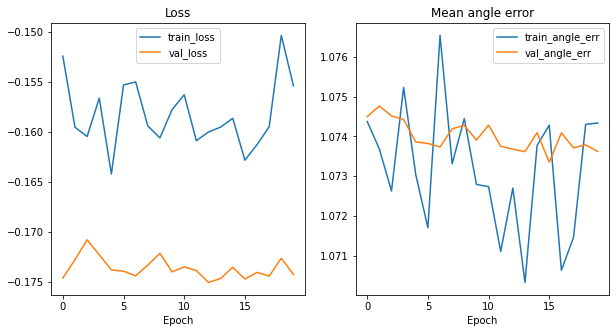

In [23]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
history_df.train_loss.plot()
history_df.val_loss.plot()
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(122)
history_df.train_angle_err.plot()
history_df.val_angle_err.plot()
plt.title('Mean angle error')
plt.xlabel('Epoch')
plt.legend()

plt.savefig(f'{SAVE_NAME}.jpg')

plt.show()